## TODO: Explain me!

In [1]:
# Hyperparams for specific model. Change accordingly.
N_BLOCKS = 6
N_HEADS = 6

In [2]:
"""
Sample from the trained model with PyTorch
"""
import json
from contextlib import nullcontext
import torch
import os, sys
from pathlib import Path

# Support absolute imports for a standalone script
sys.path.insert(0, Path.cwd().parent.as_posix())


from model import ModelArgs, Transformer, softmax_sum
from tokenizer import Tokenizer
from tinystories import get_tokenizer_model_path

# -----------------------------------------------------------------------------
start = "" # or "<|endoftext|>" or etc. Can also specify a file, use as: "FILE:prompt.txt"
max_new_tokens = 25 # number of tokens generated in each sample
temperature = 0 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
top_k = 300 # retain only the top_k most likely tokens, clamp others to have 0 probability
tokenizer = "" # override the tokenizer model path
seed = 1337
device = 'cuda' if torch.cuda.is_available() else 'cpu' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
#dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32' or 'bfloat16' or 'float16'
dtype = "float16"
compile = False # use PyTorch 2.0 to compile the model to be faster

softmax0_run = 'softmax0-15m-2023_08_26_00_08_49'
softmax1_run = 'softmax1-15m-2023_08_25_11_47_04'
softmax1_110m_run = 'artifacts/l83srejz_model:v49'
# -----------------------------------------------------------------------------

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

def load_model(out_dir):
    # init from a model saved in a specific directory
    checkpoint_dict = torch.load(f"{out_dir}/ckpt.pt", map_location=device)
    # del flash if exists
    if 'flash' in checkpoint_dict['model_args']:
        del checkpoint_dict['model_args']['flash']
    # softmax -> softmax1 in model_args
    if 'softmax' in checkpoint_dict['model_args']:
        checkpoint_dict['model_args']['softmax1'] = checkpoint_dict['model_args']['softmax']
        del checkpoint_dict['model_args']['softmax']
    gptconf = ModelArgs(**checkpoint_dict['model_args'])
    model = Transformer(gptconf)
    state_dict = checkpoint_dict['model']
    unwanted_prefix = '_orig_mod.'
    for k,v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
    model.load_state_dict(state_dict, strict=False)

    model.eval()
    model.to(device)
    if compile:
        print("Compiling the model...")
        model = torch.compile(model) # requires PyTorch 2.0 (optional)
    
    return model

def load_tokenizer(out_dir):
    # load the tokenizer
    with open(f"{out_dir}/config.json", 'r') as f:
        config = json.load(f)
    vocab_source = config.get("vocab_source", "llama2")
    vocab_size = config['vocab_size']
    if tokenizer:
        # a specific tokenizer is provided, use it
        tokenizer_model = tokenizer
    else:
        # let's try to find the tokenizer model automatically. bit gross here...
        query_vocab_size = 0 if vocab_source == "llama2" else vocab_size
        tokenizer_model = get_tokenizer_model_path(vocab_size=query_vocab_size)
    enc = Tokenizer(tokenizer_model='../tokenizer.model')
    return enc

model_softmax0 = load_model(f'../out/{softmax0_run}')
model_softmax1 = load_model(f'../out/{softmax1_run}')
model_softmax1_110m = load_model(f'../{softmax1_110m_run}')
enc = load_tokenizer(f'../out/{softmax0_run}')

def encode_prompt(start):
    if start.startswith('FILE:'):
        with open(start[5:], 'r', encoding='utf-8') as f:
            start = f.read()
    start_ids = enc.encode(start, bos=True, eos=False)
    x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])
    return x

# run generation
@torch.no_grad()
def generate(model=model_softmax1, prompt=start, max_new_tokens=max_new_tokens, temperature=temperature, top_k=top_k,
             split_token=False):
    x = encode_prompt(prompt)
    with ctx:
        y = model.generate(x, max_new_tokens, temperature, top_k)
        if split_token:
            return [enc.decode([token]) for token in y.tolist()[0]]
        return enc.decode(y.tolist())[0]

In [3]:
import torch.nn.functional as F

def compute_perplexity(prompt, model=model_softmax1_110m, max_new_tokens=max_new_tokens, temperature=temperature, top_k=top_k):
	"""
	Compute the perplexity given the logits of generated tokens and their corresponding indices.
	"""
	x = encode_prompt(prompt)
	idx, logits = model.generate(x, max_new_tokens=max_new_tokens, temperature=temperature, top_k=top_k, return_logits=True)
	probs = F.softmax(logits, dim=-1)
	actual_probs = torch.gather(probs, -1, idx.unsqueeze(-1)[:, x.shape[1]:, :])
	neg_log_probs = -torch.log(actual_probs)
	return torch.exp(torch.mean(neg_log_probs)).item()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from functools import partial
from ipywidgets import interact, fixed


def attnsum_layer_heatmap(data, layer_num, ax, vmin=0.5, vmax=1.0):
    """
    Plot a heatmap for the specified layer's softmax attention score sums.

    Parameters:
    - data: 3D numpy array containing the attention scores.
    - layer_num: Layer number to plot.
    - ax: Matplotlib axis object to plot on.
    - vmin, vmax: Color scale limits.
    """
    ax.imshow(data[layer_num], aspect="auto", cmap="inferno", vmin=vmin, vmax=vmax)
    ax.set_title(f"Layer {layer_num+1} Heatmap")
    ax.set_ylabel("Attention Heads")
    ax.set_xlabel("Seq Length")
    ax.figure.colorbar(mappable=ax.get_images()[0], ax=ax)


def attnsum_layer_histogram(data, layer_num, ax):
    """
    Plot a histogram for the specified layer.

    Parameters:
    - data: 3D numpy array containing the attention scores.
    - layer_num: Layer number to plot.
    - ax: Matplotlib axis object to plot on.
    - bin_edges: Bin edges for the histogram.
    """
    ax.hist(
        data[layer_num].flatten(), bins=50, color="cornflowerblue", alpha=0.8, log=True
    )
    ax.set_title(f"Layer {layer_num+1} Attention Distribution")
    ax.set_xlabel("Attention Score Sum")
    ax.set_ylabel("Frequency (Log)")


def attnsum_layer(S, layer_num):
    """
    Wrapper function to plot both heatmap and histogram for a specified layer.

    Parameters:
    - layer_num: Layer number to plot.
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot heatmap on the first axis
    attnsum_layer_heatmap(S, layer_num, axes[0])

    # Plot histogram on the second axis
    attnsum_layer_histogram(S, layer_num, axes[1])

    plt.tight_layout()
    plt.show()


def rolling_window(data, window_size):
    """Apply a rolling window average to data."""
    weights = np.repeat(1.0, window_size) / window_size
    return np.convolve(data, weights, "valid")


def attnsum_all(softmax_data, max_new_tokens):
    """
    Plot a heatmap and histogram for the concatenated activations across all layers.

    Parameters:
    - softmax_data: 3D numpy array containing the activations.
    - max_new_tokens: Number of tokens generated in each sample.
    """
    # Concatenate activations along the attention heads dimension
    concat_activations = softmax_data.reshape(-1, softmax_data.shape[-1])
    num_heads = softmax_data.shape[1]

    # Min of activations over seq
    min_activations = torch.min(softmax_data, dim=1).values

    fig, axes = plt.subplots(1, 3, figsize=(24, 16))

    # Plot heatmap for concatenated activations
    axes[0].imshow(concat_activations, aspect="auto", cmap="inferno")
    axes[0].set_title("Attention Score Sums")
    axes[0].set_ylabel("Nth Head of Mth Layer")
    axes[0].set_xlabel("Seq Length")
    axes[0].figure.colorbar(mappable=axes[0].get_images()[0], ax=axes[0])

    # Plot histogram for all flattened values
    axes[1].hist(
        min_activations.flatten(), bins=15, color="cornflowerblue", edgecolor="black"
    )
    axes[1].set_title("Smallest Attention Score Sum over Sequence")
    axes[1].set_xlabel("Min Attention Score / Head / Layer")
    axes[1].set_ylabel("Frequency")

    # Find bottom 10% of mean values
    threshold = torch.quantile(concat_activations.mean(dim=1), 0.1)

    # Plot multiline plot for concatenated activations
    bottom_activations = []
    for i, line in enumerate(concat_activations):
        if line.mean() <= threshold:
            axes[2].plot(
                rolling_window(line.numpy(), 4),
                label=f"Head {i//num_heads} Layer {i%num_heads}",
                alpha=0.5,
            )
            bottom_activations.append(line)
    bottom_activations = torch.stack(bottom_activations)

    axes[2].plot(
        rolling_window(bottom_activations.mean(dim=0).numpy(), 4),
        label="Mean",
        color="black",
        linewidth=2,
    )

    seq_len = softmax_data.shape[-1]

    axes[2].axvline(
        x=seq_len - max_new_tokens,
        color="red",
        linestyle="--",
        label=f"Prompt ends, completion starts",
    )

    axes[2].set_title("Attention Score Sum over Sequence (Bottom 10% Mean)")
    axes[2].set_xlabel("Seq Length")
    axes[2].set_ylabel("Attention Score Sum (Smoothened)")
    axes[2].legend()

    plt.tight_layout()
    plt.show()

Completion:   1 +  1 +  1 +  1 /  5 *  8 = ills . She was so excited to see the beautiful view . She had never seen anything like it before
torch.Size([6, 6, 38])
Token Count: 38
Perplexity: 2.5477
Overall Min: 0.5694


interactive(children=(IntSlider(value=0, description='layer_num', max=5), Output()), _dom_classes=('widget-int…

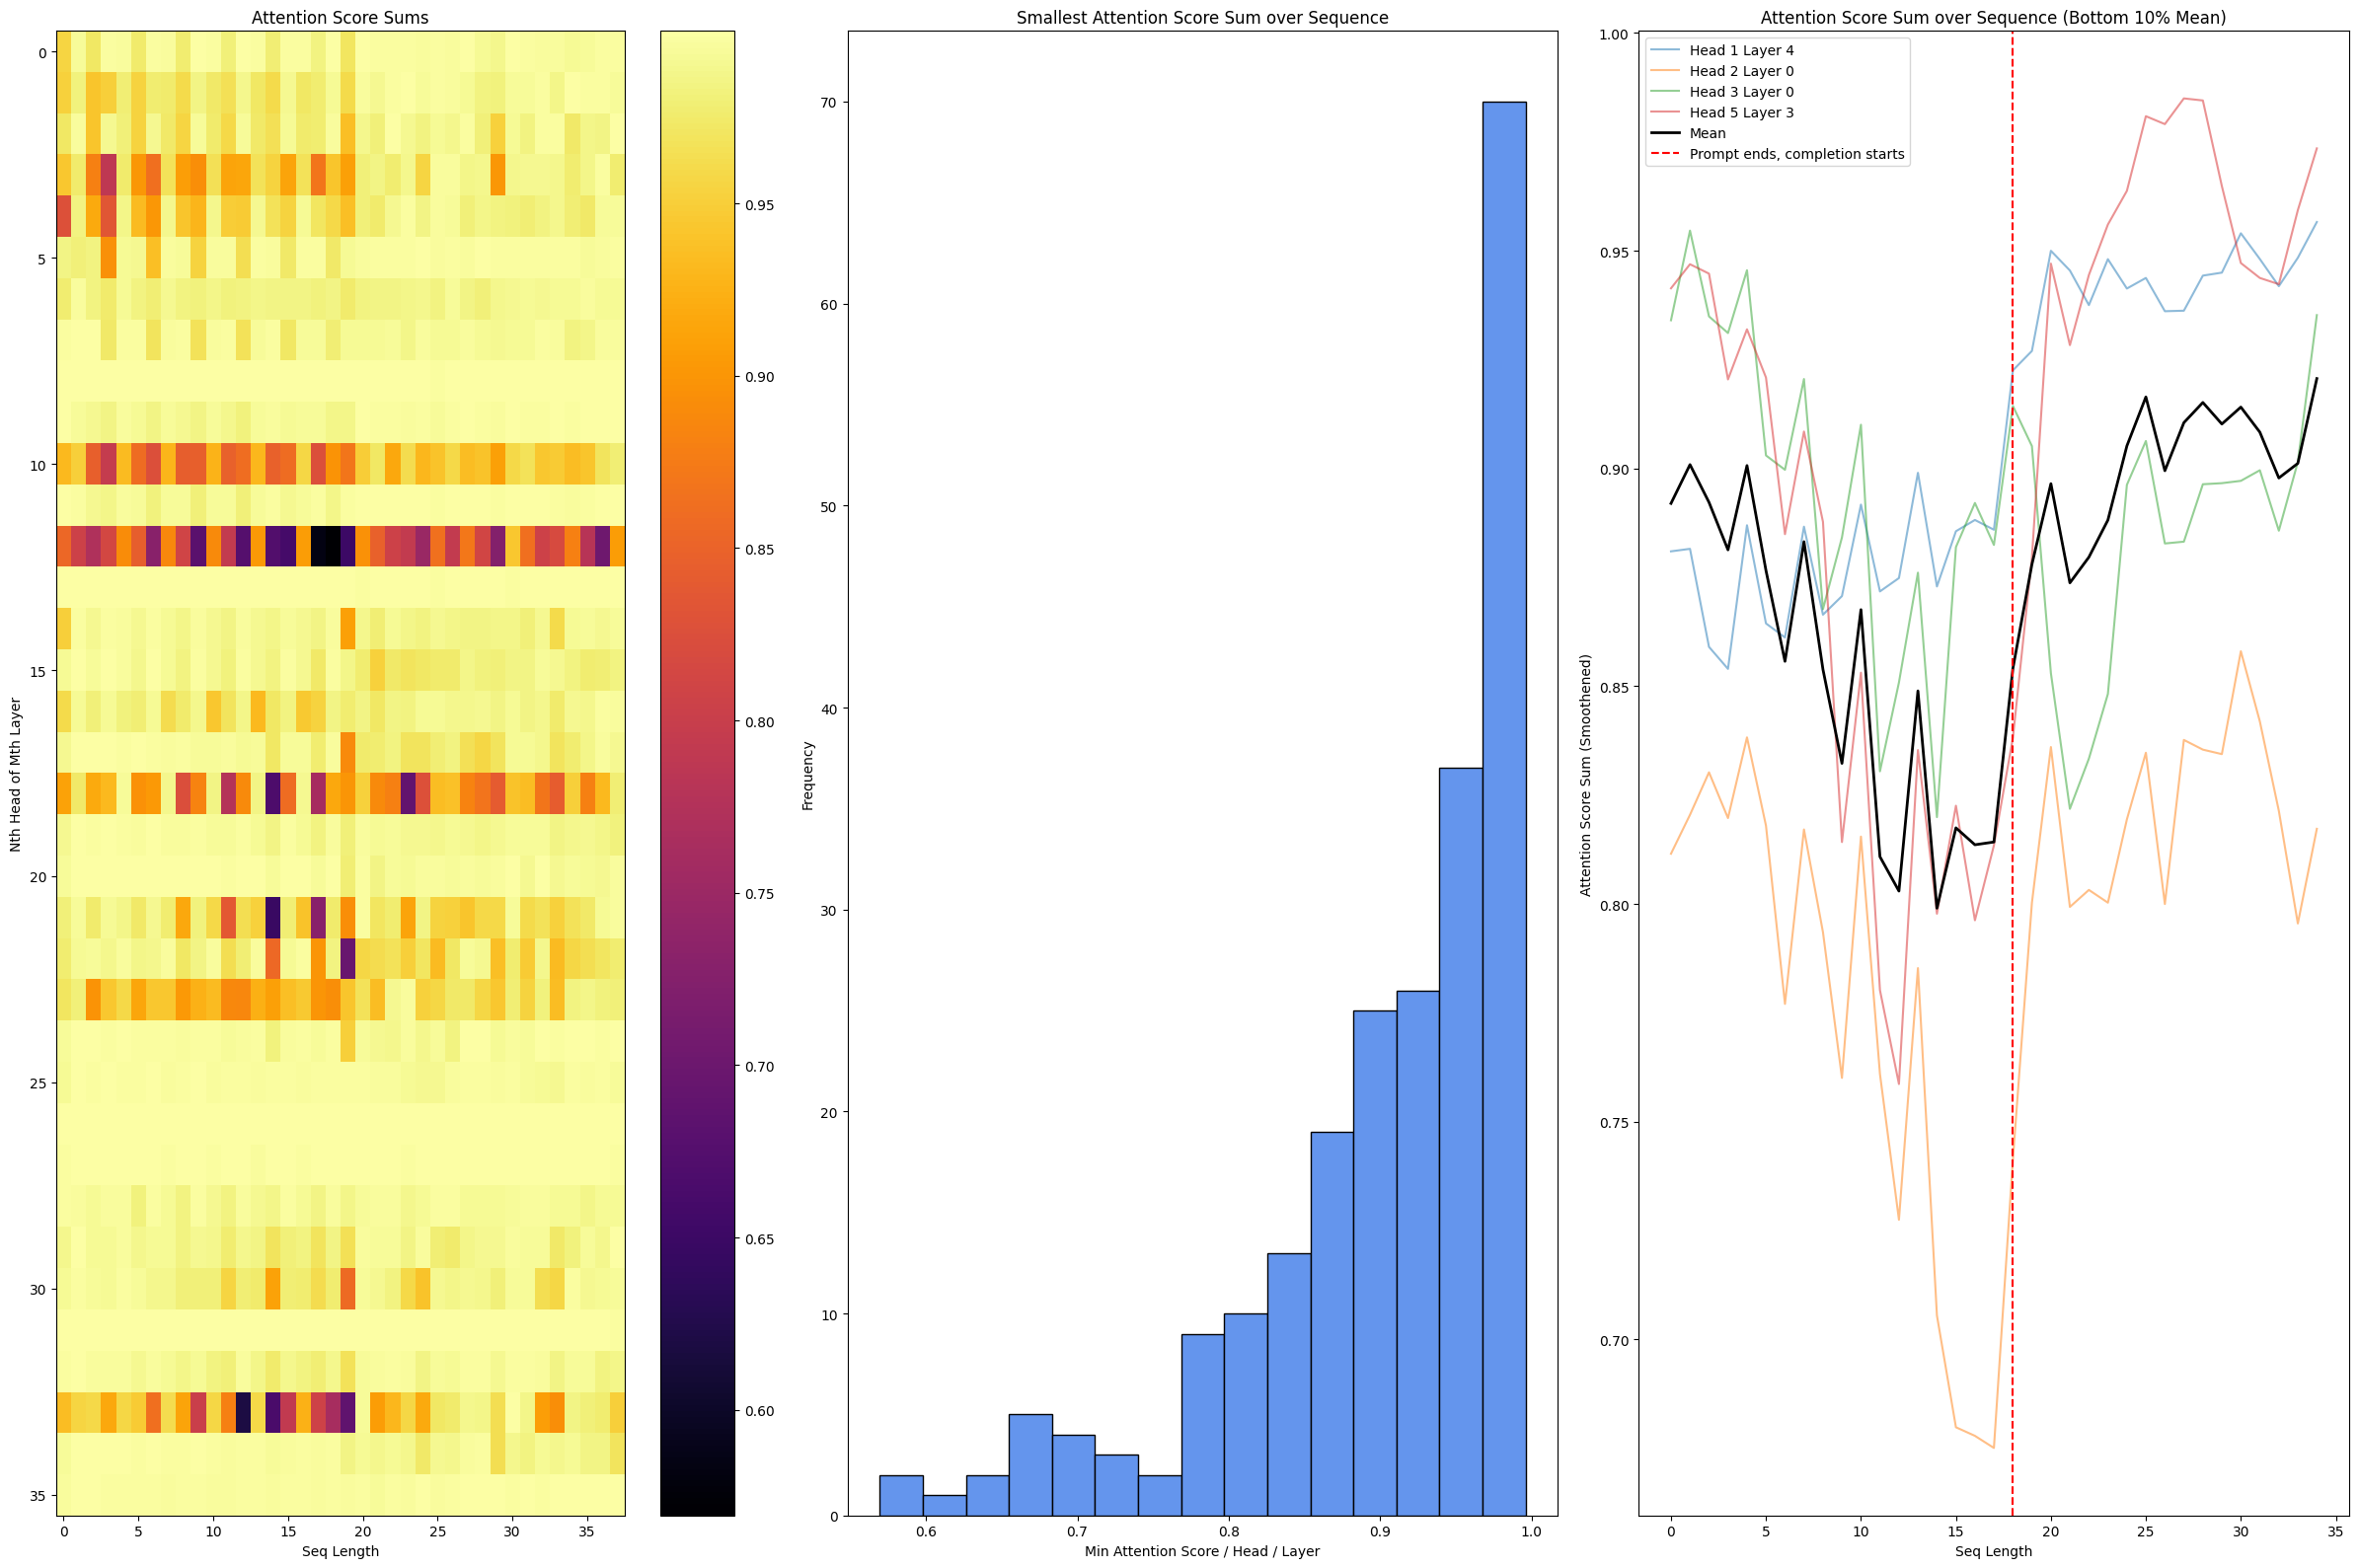

In [5]:
prompt = "1 + 1 + 1 + 1 / 5 * 8 ="
max_new_tokens = 20

ppl = compute_perplexity(prompt, max_new_tokens=max_new_tokens)
completion = generate(prompt=prompt, max_new_tokens=max_new_tokens, split_token=True)

print(f"Completion: {' '.join(completion)}")
from model import softmax_sum, attn_matrices

S = torch.stack(softmax_sum)
print(S.shape)
print(f"Token Count: {S.shape[2]}")
print(f"Perplexity: {ppl:.4f}")
print(f"Overall Min: {S.min().item():.4f}")
interact(attnsum_layer, layer_num=widgets.IntSlider(min=0, max=N_BLOCKS-1, value=0), S=fixed(S))

attnsum_all(S, max_new_tokens=max_new_tokens)

In [6]:
def add_bias_to_attention_matrix(matrix):
    """
    Adds a bias token to the attention matrix.

    This function takes an attention matrix where the sums of attention
    weights are in the range 0-1 and adds an additional 'ghost' token to
    the start of the sequence to account for the unassigned attention
    (1-sum of weights).

    Parameters:
    - matrix (torch.Tensor): The original attention matrix without the bias token.

    Returns:
    - torch.Tensor: The extended attention matrix with the bias token added.
    """
    # Calculate the bias for each row (1 - sum of each row)
    bias = 1 - matrix.sum(axis=1)
    # Create an extended matrix with an additional row and column for the bias (ghost token)
    extended_matrix = np.zeros((matrix.size(0) + 1, matrix.size(1) + 1))
    # Copy the original attention matrix to the extended matrix (excluding the added row and column)
    extended_matrix[1:, 1:] = matrix
    # The bias (1 - sum) will be added as the first element (ghost token) of each row
    extended_matrix[1:, 0] = bias
    # The ghost token doesn't attend to anything so its attention is 0
    extended_matrix[0, :] = 0
    # The attention to the ghost token itself is set to 1
    extended_matrix[0, 0] = 1
    return extended_matrix


def plot_attention_heatmap(
    matrix, layer_idx, head_idx, token_sequence=None, ax=None, figsize=(9, 8)
):
    """
    Plots a heatmap of the attention matrix.

    Given an extended attention matrix with a bias token, this function
    plots the heatmap with appropriate labels and color scales.

    Parameters:
    - matrix (np.ndarray): The extended attention matrix with the bias token.
    - layer_idx (int): The index of the layer for the title.
    - head_idx (int): The index of the head for the title.
    - token_sequence (list): The sequence of tokens for the axes.
    - ax (matplotlib.axes.Axes): The axis to plot on.
    - figsize (tuple): The figure size for the plot.
    """
    if ax is None:
        _, ax = plt.subplots(figsize=figsize)

    im = ax.imshow(matrix, cmap="inferno", aspect="equal")
    ax.figure.colorbar(mappable=ax.get_images()[0], ax=ax)

    # Enhancing the plot with titles and labels
    ax.set_title(f"'{' '.join(token_sequence)}'\nAttention Matrix (Head {head_idx+1}, Block {layer_idx+1})")
    ax.set_xlabel("Sequence Position")
    ax.set_ylabel("Sequence Position")
    ax.grid(False)

    # Adjusting the tick labels to include the bias token
    x_labels = ["Bias"] + list(range(matrix.shape[1] - 1))
    y_labels = ["Bias"] + list(range(matrix.shape[0] - 1))

    if token_sequence:
        x_labels, y_labels = [["Bias"] + token_sequence] * 2

    # Setting the correct tick labels
    ax.set_xticks(ticks=np.arange(matrix.shape[1]))
    ax.set_xticklabels(x_labels, rotation=-90)
    ax.set_yticks(ticks=np.arange(matrix.shape[0]))
    ax.set_yticklabels(y_labels)

In [7]:
prompt = "1 + 1 + 1 + 1 + 1 ="
max_new_tokens = 10

sum_arr = []
matrix_arr = []
for m in [model_softmax0, model_softmax1]:
    completion = generate(
        model=m, prompt=prompt, max_new_tokens=max_new_tokens, split_token=True
    )
    print(f"Completion: {' '.join(completion)}")
    from model import softmax_sum, attn_matrices

    sum_arr.append(torch.stack(softmax_sum))
    matrix_arr.append(torch.stack(attn_matrices))


# Testing the functions by plotting the heatmap for Layer 1, Head 4 (index 3)
def plot(layer_index, head_index):
    fig, axs = plt.subplots(2, 2, figsize=(18, 16))

    for i, (A, S) in enumerate(zip(matrix_arr, sum_arr)):
        attnsum_layer_heatmap(data=S, layer_num=layer_index, ax=axs[0, i])

        attention_matrix = A[layer_index, head_index]
        extended_matrix = add_bias_to_attention_matrix(attention_matrix)
        # Label empty string in index 1 as <bos>; and last output token (y[-1]) not included in attn matrix
        token_seq = ["<bos>"] + completion[1:-1]
        plot_attention_heatmap(
            extended_matrix, layer_index, head_index, token_seq, ax=axs[1, i]
        )


block = widgets.IntSlider(min=0, max=N_BLOCKS - 1, value=0)
head = widgets.IntSlider(min=0, max=N_HEADS - 1, value=0)

display(block)
display(head)
display(widgets.interactive_output(plot, {"layer_index": block, "head_index": head}))

Completion:   1 +  1 +  1 +  1 +  1 = - 2 - 2 - 3 - 2 - 2
Completion:   1 +  1 +  1 +  1 +  1 = c ud nod ding . He was so excited to


IntSlider(value=0, max=5)

IntSlider(value=0, max=5)

Output()